In [1]:
import os
import re
import string

import tensorflow as tf

import matplotlib.pyplot as plt

devices = tf.config.list_physical_devices('GPU')
print(devices)
try:
    tf.config.experimental.set_memory_growth(devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Multi-class text classification analysis

### Dataset

In [2]:
dataset_dir = 'D:\\dataset\\stack_overflow_16k'
os.listdir(dataset_dir)

['README.md', 'train', 'test']

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

print(os.listdir(train_dir))
print(os.listdir(test_dir))

['python', 'java', 'csharp', 'javascript']
['python', 'java', 'csharp', 'javascript']


In [4]:
sample = os.path.join(train_dir, 'python', '0.txt')
with open(sample) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [5]:
batch_size = 32
seed = 111

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Text: ", text_batch.numpy()[i])
        print("Label: ", label_batch.numpy()[i])
        if '<br />' in text_batch:
            print('yes')
        else:
            print('no')

Text:  b'"comparing 2 int arrays can anyone tell me whats wrong in this method and why it gives a nullpointerexception ?..public boolean check(){..    scanner scan = new scanner(system.in);..    int[] arr1 = new int []{1,2,3};.    int[] arr2 = new int[]{};..    for(int i = 0;i&lt;arr1.length;i++).    {.        system.out.println(""enter numbers to check"");.        arr2[i] = scan.nextint();.    }..    if(arr1 == arr2).        return true;..    return false;.}"\n'
Label:  1
no
Text:  b'"for-loop setting length variable when converting from nodelist phew! that was a long title...i\'m reading wrox\' book on professional blank for web developers and i came across this sample code, and i was just wondering if that was best practice:..function converttoarray(nodes) {.   array = new array();.   for (var i=0, len=nodes.length; i &lt; len; i++) {.      array.push(nodes[i]);.   }.   return array;.}...the thing that\'s got me scratching my head is the ""len=nodes.length"". am i wrong in thinking 

In [7]:
print('Label 0: ', raw_train_ds.class_names[0])
print('Label 1: ', raw_train_ds.class_names[1])
print('Label 2: ', raw_train_ds.class_names[2])
print('Label 3: ', raw_train_ds.class_names[3])

Label 0:  csharp
Label 1:  java
Label 2:  javascript
Label 3:  python


In [8]:
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [9]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


### Preprocessing

In [10]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [12]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [13]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [14]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]

print('Vectorized: ', vectorize_text(first_question, first_label))

Vectorized:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  16,   52,  321,  114,    2,  123,   30,  119,   21,  148,    2,
          27,   52,  321,    6,   13,    5, 1769,   44,    1,  195,   52,
         195,   39,  761,   19,   52,    1,    1,   41,  108,   27,   87,
          19,   52,   42,  153,   43,   88,    1,    3,  129,   17,    5,
         846,  209,  171,   24,   13,    6,   53, 2335,    4,   74, 1183,
           2,   52,  321,    6,  692,  236,   24,   10,    6,  236,   46,
           1,    6,    5,  391,    1,  252,   14,   52,  321,    6,  236,
          46,   99,  261,    6,  263,   44,    5,  391,    6, 2203,  542,
          67,    5,  391, 1377,    2, 4075, 1178,    1,   35,  402,   12,
          82, 1426,   38,  109,    2,  239,  119,   21, 1340,   52,  321,
          46,  239,    6, 1178,   36,  122,  297,    8,   71,  391,   10,
           6,  102,  269,    1,    4,   74,    8,   14,    6,  109,    3,
         625,   10,  167,   33,    5, 1769,    0, 

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [16]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

### Model

In [17]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [18]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

### Train

In [19]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/20
200/200 [==============================] - 4s 16ms/step - loss: 1.3791 - accuracy: 0.3452 - val_loss: 1.3714 - val_accuracy: 0.4475
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 1.3537 - accuracy: 0.4553 - val_loss: 1.3405 - val_accuracy: 0.4769
Epoch 3/20
200/200 [==============================] - 2s 9ms/step - loss: 1.3084 - accuracy: 0.5211 - val_loss: 1.2896 - val_accuracy: 0.5387
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 1.2428 - accuracy: 0.5772 - val_loss: 1.2239 - val_accuracy: 0.5794
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 1.1635 - accuracy: 0.6225 - val_loss: 1.1528 - val_accuracy: 0.6112
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 1.0868 - accuracy: 0.6622 - val_loss: 1.0851 - val_accuracy: 0.6556
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 1.0135 - accuracy: 0.6989 - val_loss: 1.0235 - val_accuracy: 0.6869
Epoch

### Evaluate

In [20]:
model.evaluate(test_ds)

250/250 [==============================] - 13s 48ms/step - loss: 0.6460 - accuracy: 0.7756


[0.6460193395614624, 0.7756249904632568]

### Visualization

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history_dict['accuracy']
loss = history_dict['loss']
val_acc = history_dict['val_accuracy']
val_loss = history_dict['val_loss']

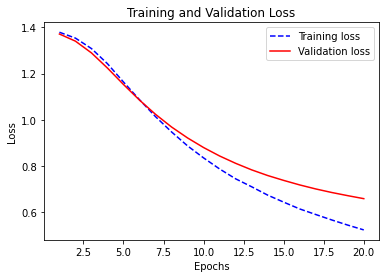

In [24]:
epochs = range(1, EPOCHS + 1)

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

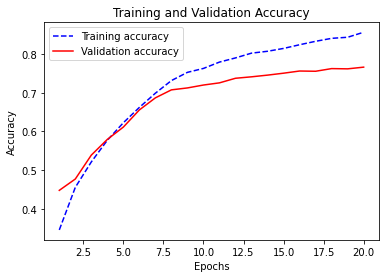

In [25]:
plt.plot(epochs, acc, 'b--', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()